This notebook contains the analysis and solution for the Sr. Business Analyst technical challenge. 
The goal is to assess the financial viability of a credit startup and to propose data-driven strategies to ensure its sustainability

Executive Summary

The analysis shows that the startup’s current push for fast growth is not financially sustainable and will keep causing bigger losses over the next year. The main problem is that the high-risk Contigo A product is not profitable.

The main recommendation is to shift from a grow at all costs mindset to a more sustainable approach. This means using data to improve collections, adjusting product pricing and costs, and focusing more on growing the more stable Contigo B segment.

The analysis will be divided into two main parts:

1) The primary task is to forecast the company's net income for the next 12 months.
This forecast must account for two credit products (contigo a and contigo b), their respective growth rates, operational costs, interest rates, and, crucially, their estimated debt delinquency (DQ) rate

2) This part evaluates the impact of a phone call campaign targeting delinquent customers of the contigo a product during the first month of operation. The analysis will be based on the campaign's costs and the probability of successful debt collection, using the provided contactability data

Action plan:

1. Import the necessary libraries (Pandas, Matplotlib, Pandasql).
2. Load the `BA Hiring - Collections Challenge.csv` file and perform an initial inspection to check its integrity (nulls, duplicates, data types).
3. First analysis part:
- Build a DataFrame to simulate the month-over-month growth in customers, revenue, DQ losses, and costs.
- Calculate the monthly and cumulative Net Income.
- Visualize key trends and answer the strategic questions from the case study.
4. Second analysis part:
- Use the contactability DataFrame to calculate the campaign's KPIs (recovered accounts, costs, campaign net income).
- Generate the requested SQL query.
- Assess and justify the campaign's viability by comparing the outcome against the baseline scenario.
- Propose improvements to the collection strategy.

Conclusions and suggestions are mentioned at the end. 

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf #important to prove our query at the end 

#load data
contactability_df = pd.read_csv("BA Hiring - Collections Challenge.csv")

#initial Data Integrity Check
print("Initial data preview")
contactability_df_raw = pd.read_csv("BA Hiring - Collections Challenge.csv")
print(contactability_df_raw.head())
print("Initial duplicate rows check")
duplicate_rows = contactability_df_raw.duplicated().sum()
print(f"Total number of duplicate rows found: {duplicate_rows}")

Initial data preview
   customer_id  contactability_score  Unnamed: 2  Unnamed: 3  Unnamed: 4  \
0          1.0                 0.293         NaN         NaN         NaN   
1          2.0                 0.250         NaN         NaN         NaN   
2          3.0                 0.033         NaN         NaN         NaN   
3          4.0                 0.239         NaN         NaN         NaN   
4          5.0                 0.681         NaN         NaN         NaN   

   Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  ...  \
0         NaN         NaN         NaN         NaN         NaN  ...   
1         NaN         NaN         NaN         NaN         NaN  ...   
2         NaN         NaN         NaN         NaN         NaN  ...   
3         NaN         NaN         NaN         NaN         NaN  ...   
4         NaN         NaN         NaN         NaN         NaN  ...   

   Unnamed: 11  Unnamed: 12  Unnamed: 13  Unnamed: 14  Unnamed: 15  \
0          NaN          NaN    

The initial check reveals two issues:
1. The presence of multiple "Unnamed" columns with no data.
2. A total of 323 duplicate rows, which are likely empty lines at the end of the CSV file.

The next step is to clean the data to address these problems.

In [2]:
#data loading and cleaning

#load data again, selecting only the columns we need.
contactability_df = pd.read_csv(
    "BA Hiring - Collections Challenge.csv", 
    usecols=['customer_id', 'contactability_score']
)

#drop empty rows and set the correct data type for customer_id.
contactability_df.dropna(how='all', inplace=True)
contactability_df['customer_id'] = contactability_df['customer_id'].astype(int)

In [3]:
#final data integrity check

print("Cleaned data preview")
print(contactability_df.head())

print("Final null value check")
print(contactability_df.isnull().sum())

print("Final duplicate rows check")
duplicate_rows_clean = contactability_df.duplicated().sum()
print(f"Total number of duplicate rows found after cleaning: {duplicate_rows_clean}")

contactability_df.info()

Cleaned data preview
   customer_id  contactability_score
0            1                 0.293
1            2                 0.250
2            3                 0.033
3            4                 0.239
4            5                 0.681
Final null value check
customer_id             0
contactability_score    0
dtype: int64
Final duplicate rows check
Total number of duplicate rows found after cleaning: 0
<class 'pandas.core.frame.DataFrame'>
Index: 675 entries, 0 to 674
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           675 non-null    int32  
 1   contactability_score  675 non-null    float64
dtypes: float64(1), int32(1)
memory usage: 13.2 KB


In [4]:
#first part forecast analysis 
#variable definition

#contigo A parameters (high risk clients)
contigo_a_initial_customers = 5000
contigo_a_growth_rate = 0.25
contigo_a_loan = 1000
contigo_a_interest_rate = 0.15
contigo_a_dq_rate = 0.135

#contigo B parameters (low risk clients)
contigo_b_initial_customers = 10000
contigo_b_growth_rate = 0.10
contigo_b_loan = 2000
contigo_b_interest_rate = 0.10
contigo_b_dq_rate = 0.08

# General parameters
operative_cost_per_account = 30
months_to_forecast = 12

#forecast df 

forecast_data = [] #creating an empty list to be fill with our function and the customers' counters with the previous defined values
current_customers_a = contigo_a_initial_customers 
current_customers_b = contigo_b_initial_customers

for month in range(1, months_to_forecast + 1): #with this we secure to forecast all the months (repeting the calculations 12 times)
    
    if month > 1: #because in month 1 we use the initial data
        current_customers_a *= (1 + contigo_a_growth_rate) #with these variables we take the previous month row and calculate the rate month by month
        current_customers_b *= (1 + contigo_b_growth_rate)
        
    total_customers = current_customers_a + current_customers_b #calculating total with the results of the two variables
    
    #revenue calculation using the # of clients * % of clients omiting the ones that do not pay *interest rate
    revenue_a = current_customers_a * (1 - contigo_a_dq_rate) * (contigo_a_loan * contigo_a_interest_rate)
    revenue_b = current_customers_b * (1 - contigo_b_dq_rate) * (contigo_b_loan * contigo_b_interest_rate)
    total_revenue = revenue_a + revenue_b
    
    #dq losses calculation using the # of clients who do not pay (obtained with the dq rate)*the amount of the loan
    losses_a = current_customers_a * contigo_a_dq_rate * contigo_a_loan
    losses_b = current_customers_b * contigo_b_dq_rate * contigo_b_loan
    total_losses = losses_a + losses_b
    
    #operative costs calculation using the # of total clients * the cost to operate each account
    total_operative_costs = total_customers * operative_cost_per_account
    
    #net income calculation using the total revenue and extracting the losses and the operative costs
    net_income = total_revenue - total_losses - total_operative_costs
    
    #created a dictionary to append all the data obtain from our calculations to the empty list forecast_data
    forecast_data.append({
        'Month': month,
        'Contigo_A_Customers': int(round(current_customers_a)),
        'Contigo_B_Customers': int(round(current_customers_b)),
        'Total_Customers': int(round(total_customers)),
        'Total_Revenue': round(total_revenue, 2),
        'Total_DQ_Losses': round(total_losses, 2),
        'Operative_Costs': round(total_operative_costs, 2),
        'Net_Income': round(net_income, 2)
    })

#with the list we create a dataframe for better visibility
forecast_df = pd.DataFrame(forecast_data).set_index('Month')

#show the results 
print("12-month financial forecast for Stori")
forecast_df

12-month financial forecast for Stori


,Contigo_A_Customers,Contigo_B_Customers,Total_Customers,Total_Revenue,Total_DQ_Losses,Operative_Costs,Net_Income
Month,,,,,,,
1,5000,10000,15000,2488750.00,2275000.00,450000.00,-236250.00
2,6250,11000,17250,2834937.50,2603750.00,517500.00,-286312.50
3,7812,12100,19912,3240071.88,2990687.50,597375.00,-347990.62
4,9766,13310,23076,3716129.84,3447959.38,692268.75,-424098.28
5,12207,14641,26848,4277806.30,3990509.22,805440.94,-518143.85
6,15259,16105,31364,4943166.28,4636752.52,940916.67,-634502.91
7,19073,17716,36789,5734457.09,5409418.25,1103672.89,-778634.05
8,23842,19487,43329,6679120.53,6336598.18,1299870.87,-957348.52
9,29802,21436,51238,7811054.74,7453055.62,1537146.31,-1179147.19


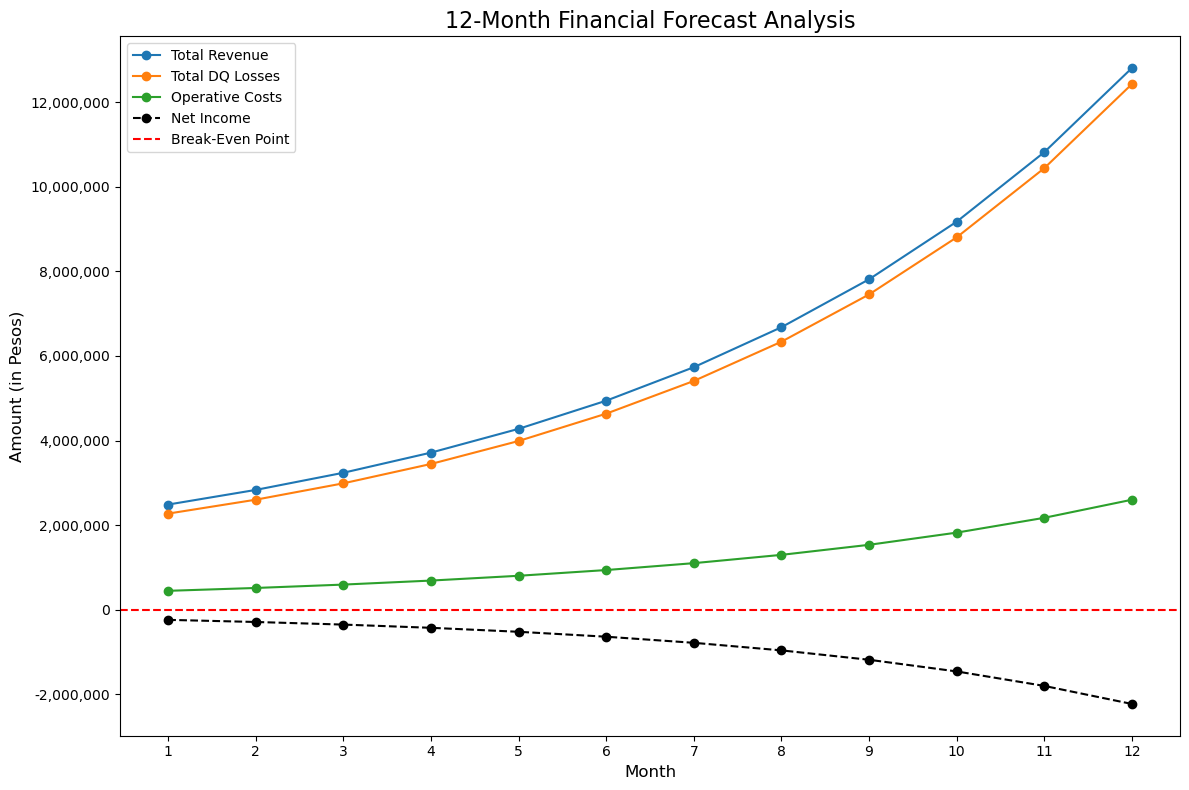

In [5]:
#12 month forecast visualization 

# Create the plot
plt.figure(figsize=(12, 8))

#setting graph variables
plt.plot(forecast_df.index, forecast_df['Total_Revenue'], label='Total Revenue', marker='o', linestyle='-')
plt.plot(forecast_df.index, forecast_df['Total_DQ_Losses'], label='Total DQ Losses', marker='o', linestyle='-')
plt.plot(forecast_df.index, forecast_df['Operative_Costs'], label='Operative Costs', marker='o', linestyle='-')
plt.plot(forecast_df.index, forecast_df['Net_Income'], label='Net Income', marker='o', linestyle='--', color='black')

#graph details
plt.axhline(y=0, color='red', linestyle='--', label='Break-Even Point')
plt.title('12-Month Financial Forecast Analysis', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Amount (in Pesos)', fontsize=12)
plt.xticks(forecast_df.index)
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.legend()

#showing the graph
plt.tight_layout()
plt.show()

As we can see, the net income (dotted line black) stays below zero across the year, which means that under current growth, cost, and default rate conditions, the startup won’t be profitable in the next 12 months, in fact, its losses keep increasing over time. 

The chart also highlights the main challenges to profitability: total losses and operating costs are growing exponentially, while revenue is rising too but not fast enough to offset these rising losses and expenses.

In [6]:
#part 2 analysis of collection strategy
#parameters for Contigo A
customers_a = 5000
interest_rate_a = 0.15
loan_a = 1000
dq_rate_a = 0.135
cost_per_account = 30

#calculate financial components for Contigo A
revenue_a = customers_a * (1 - dq_rate_a) * (loan_a * interest_rate_a)
losses_a = customers_a * dq_rate_a * loan_a
costs_a = customers_a * cost_per_account

#calculate Net Income for Contigo A
net_income_a = revenue_a - losses_a - costs_a

print(f"Revenue (Contigo A, Month 1): ${revenue_a:,.2f}")
print(f"DQ losses (Contigo A, Month 1): ${losses_a:,.2f}")
print(f"Operative costs (Contigo A, Month 1): ${costs_a:,.2f}")
print(f"Net income (Contigo A, Month 1): ${net_income_a:,.2f}")

Revenue (Contigo A, Month 1): $648,750.00
DQ losses (Contigo A, Month 1): $675,000.00
Operative costs (Contigo A, Month 1): $150,000.00
Net income (Contigo A, Month 1): $-176,250.00


In [7]:
#define campaign parameters and calculate KPIs
dq_customers_count = 675 #clients who did not pay in month 1
cost_per_call = 30 #cost to make a call
payment_prob_if_contacted = 0.75 #probability that the client pays if contacted
loan_per_customer = 1000 #contigo loan amount
interest_per_customer = 150 #1000 * 0.15  #interest generated for each loan

#calculate expected recoveries

#calculate the individual probability of recovery for each customer
contactability_df['recovery_prob'] = contactability_df['contactability_score'] * payment_prob_if_contacted

#calculate the total expected number of recovered accounts by summing probabilities
expected_recovered_accounts = contactability_df['recovery_prob'].sum()

#calculate campaign kpis

#expected recovered debt
expected_recovered_debt = expected_recovered_accounts * loan_per_customer #multiply recovered accounts by the loan amount (1000) to find the recovered amount

#expected recovered revenue
expected_recovered_revenue = expected_recovered_accounts * interest_per_customer #multiply recovered accounts by the interest amount (150) to find the amount generated in interest

#total campaign cost
total_campaign_cost = dq_customers_count * cost_per_call #multiply the number of customers contacted by the cost per call

#initial total debt at risk (the maximum loss if nothing is done to recover)
initial_total_debt_at_risk = dq_customers_count * loan_per_customer #total clients who did not pay * loan amount

#dq losses remaining after the campaign
remaining_dq_losses = initial_total_debt_at_risk - expected_recovered_debt #original debt minus the recovered amount

#collections income (net result of the campaign)
collections_income = (expected_recovered_debt + expected_recovered_revenue) - total_campaign_cost #money recovered (principal + interest) minus the campaign cost


#print kpis
print(f"Expected recovered accounts: {expected_recovered_accounts:.2f}")
print(f"Expected recovered Total Debt (Principal): ${expected_recovered_debt:,.2f}")
print(f"Expected revenue from collected interest: ${expected_recovered_revenue:,.2f}")
print(f"Total campaign cost: ${total_campaign_cost:,.2f}")
print(f"DQ losses remaining from uncollected debt: ${remaining_dq_losses:,.2f}")
print(f"\nCollections net income: ${collections_income:,.2f}")

Expected recovered accounts: 212.02
Expected recovered Total Debt (Principal): $212,024.25
Expected revenue from collected interest: $31,803.64
Total campaign cost: $20,250.00
DQ losses remaining from uncollected debt: $462,975.75

Collections net income: $223,577.89


The analysis shows that the proposed collections campaign will have a strong positive impact. It is expected to recover about 212 of the 675 delinquent accounts, bringing in \$212,024.24 in principal and \$31,803.64 in interest, with a total cost of $20,250.00. This results in net collections income of \$223,577.89, delivering a solid return.

Without the campaign, this group represents a total loss of \$675,000. After the campaign, remaining losses would drop to \$462,975.75, greatly reducing risk.

Most importantly, the campaign alone turns the Contigo A segment profitable for the month. Starting with a baseline loss of -\$176,250.00, adding the campaign’s net income flips the result to a net gain of \$47,327.89.

In short, the campaign more than pays for itself and is key to moving this high-risk segment from loss to profit.

In [8]:

#created the SQL query as a multi-line string, we will query the df named 'contactability_df'
query = """
    WITH CampaignBase AS (
        SELECT
            SUM(contactability_score * 0.75) AS total_expected_recoveries,
            COUNT(customer_id) AS total_dq_customers
        FROM
            contactability_df -- refering to our pandas df
    )
    SELECT
        total_expected_recoveries AS "Expected Recovered Accounts", -- Renaming the columns for better understanding
        total_expected_recoveries * 1000 AS "Recovered Total Debt",
        total_expected_recoveries * 150 AS "Revenue from Collected Interest",
        total_dq_customers * 30 AS "Total Campaign Cost",
        (total_dq_customers * 1000) - (total_expected_recoveries * 1000) AS "DQ Losses from Uncollected Debt",
        (total_expected_recoveries * 1150) - (total_dq_customers * 30) AS "Collections Income"
    FROM
        CampaignBase;
"""

#execute the query using pandasql
sql_results_df = sqldf(query, locals())

#display the results
print("Results from sql query executed on pandas df")
print(sql_results_df)

Results from sql query executed on pandas df
   Expected Recovered Accounts  Recovered Total Debt  \
0                    212.02425             212024.25   

   Revenue from Collected Interest  Total Campaign Cost  \
0                       31803.6375                20250   

   DQ Losses from Uncollected Debt  Collections Income  
0                        462975.75         223577.8875  


The analysis confirms that the collections campaign for the Contigo A product is both profitable and necessary. On its own, it generates about \$223,578 in net income, turning an initial loss of -\$176,250 into a net gain of \$47,328 in the first month. 

Immediate implementation is recommended, focusing calls on customers with a higher contactability score to maximize the return.

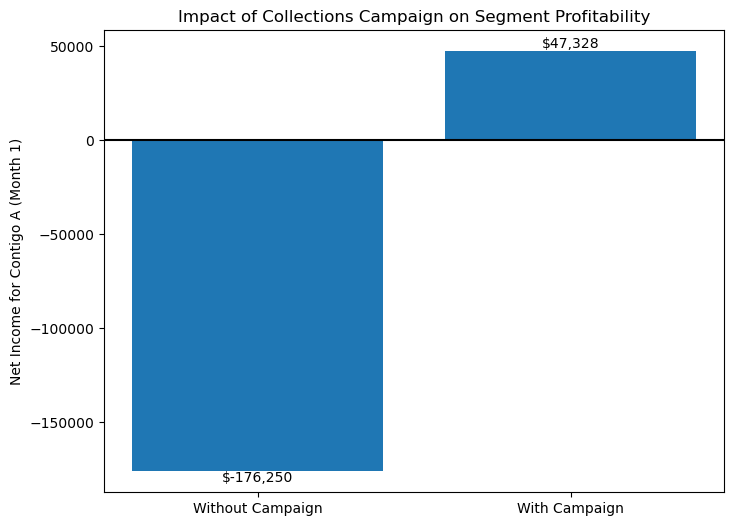

In [9]:
#visualizing the campaign's impact on net income
scenarios = ['Without Campaign', 'With Campaign']
net_incomes = [-176250, 47328]

plt.figure(figsize=(8, 6))
bars = plt.bar(scenarios, net_incomes)
plt.ylabel('Net Income for Contigo A (Month 1)')
plt.title('Impact of Collections Campaign on Segment Profitability')
plt.axhline(y=0, color='black', linestyle='-') #break-even line
#adding labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'${int(yval):,}', va='bottom' if yval > 0 else 'top', ha='center')
plt.show()

Strategic action plan

1. Product graduation system
Idea: Instead of keeping risky customers in the same segment forever, create a clear path for them to earn better terms. For example, if a Contigo A customer pays on time for 3–4 months, they could “graduate” to Contigo B or an intermediate loan with lower rates and higher limits. 
This motivates high-risk customers to pay on time, lowering delinquency and increasing customer lifetime value.

2. Make payments feel rewarding (Gamification plan)
Turn paying on time into an achievement. In the app, customers could earn points, badges, or level up for each on-time payment. A perfect record could unlock perks or a special status on their profile.

Uses positive reinforcement to boost engagement and makes customers more likely to prioritize payments to keep their “streak.”

3. Build a value-added ecosystem 
Offer more than just a loan. Partner with other companies to give loyal customers extra benefits, like mobile top-up discounts, free financial education courses, or budgeting tools.

Makes the loan part of a broader financial wellness experience. Customers see more value in staying on track so they don’t lose these perks.

Conclusion

Profitability won’t come just from raising rates. The key is building a win-win relationship where customers are rewarded for good behavior. By investing in their success, the startup can reduce risk, boost retention, and build a truly sustainable business.